<a href="https://colab.research.google.com/github/SashaWald/Week3_Public/blob/master/Preliminary_CNN_(X_Ray_data_only).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

feel free to make copies of this notebook so we can have multiple models training at the same time

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# File manipulation and IO (input/output)
import os, shutil
import pickle
import zipfile
from google.colab import files

# Import numerical and dataframe handling
import numpy as np
import scipy
import pandas as pd

# Data preprocessing
from PIL import Image
from sklearn.utils import shuffle

# Model scoring
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Import standard machine learning machinery
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# Garbage collection (for saving RAM during training)
import gc

# Import plotting functionality
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import matplotlib
import skimage.transform as transform

This loads all the X-Ray data into DirectoryIterator objects. Rudimentary data augmentation has already been performed on the training data

In [3]:
image_height = 256
image_width = 256
seed = 999

one_hot_to_string = [([1.,0.,0.,0.,0.],'NORMAL'),
                    ([0.,1.,0.,0.,0.],'COVID-19'),
                    ([0.,0.,1.,0.,0.],'BACTERIAL PNEUMONIA'),
                    ([0.,0.,0.,1.,0.],'VIRAL PNEUMONIA'),
                    ([0.,0.,0.,0.,1.],'TUBERCULOSIS')]

base_dir = '/content/gdrive/My Drive/covid project'
Xray_train_dir = os.path.join(base_dir, 'Xray_images')
Xray_val_dir = os.path.join(base_dir, 'Xray_images_val')
Xray_test_dir = os.path.join(base_dir, 'Xray_images_test')


train_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=45,
                                                                width_shift_range=.15,
                                                                height_shift_range=.15,
                                                                horizontal_flip=True,
                                                                zoom_range=0.5,
                                                                samplewise_std_normalization=True)


val_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                samplewise_std_normalization=True)

print('Xray image info (train, val, test):')
train_xray = train_augmented.flow_from_directory(Xray_train_dir, target_size=(image_height, image_width), color_mode='rgb', seed=seed)
val_xray = val_generator.flow_from_directory(Xray_val_dir, target_size=(image_height, image_width), color_mode='rgb', seed=seed)
test_xray = val_generator.flow_from_directory(Xray_test_dir, target_size=(image_height, image_width), color_mode='rgb', seed=seed)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Xray image info (train, val, test):
Found 6185 images belonging to 5 classes.
Found 1543 images belonging to 5 classes.
Found 1930 images belonging to 5 classes.


Load a few images from the validation set. (note: this might change the order of the samples called from the generator, so before you run any models feel free to re-initialize the data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


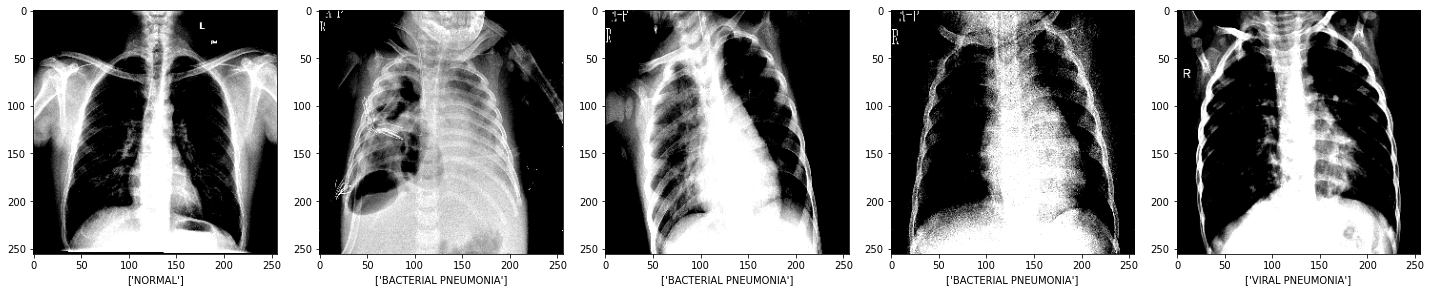

In [ ]:
samples, labels = next(val_xray)

five_samples = samples[:5]
five_labels = labels[:5]

fig, axes=plt.subplots(1,5,figsize=(20,20))
axes=axes.flatten()
for num, (img, ax) in enumerate(zip(five_samples, axes)):
  ax.imshow(img)
  one_hot = five_labels[num]
  ax.set_xlabel([y for x,y in one_hot_to_string if x == list(one_hot)])
plt.tight_layout()
plt.show()

In [ ]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(image_height, image_width, 3)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
flatten (Flatten)            (None, 1048576)           0         
_________________________________________________________________
dense (Dense)                (None, 32)                33554464  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 33,555,077
Trainable params: 33,555,077
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()


history = model.fit(train_xray,
                    epochs=10,
                    callbacks=[garbage_collect_callback()],
                    validation_data=val_xray,
                    verbose=1)

Epoch 1/10
194/194 [==============================] - 3795s 20s/step - loss: 11.4386 - accuracy: 0.2867 - val_loss: 11.4801 - val_accuracy: 0.2878
Epoch 2/10
194/194 [==============================] - 309s 2s/step - loss: 11.4794 - accuracy: 0.2878 - val_loss: 11.4801 - val_accuracy: 0.2878
Epoch 3/10
194/194 [==============================] - 309s 2s/step - loss: 11.4794 - accuracy: 0.2878 - val_loss: 11.4801 - val_accuracy: 0.2878
Epoch 4/10
194/194 [==============================] - 309s 2s/step - loss: 11.4794 - accuracy: 0.2878 - val_loss: 11.4801 - val_accuracy: 0.2878
Epoch 5/10
194/194 [==============================] - 309s 2s/step - loss: 11.4794 - accuracy: 0.2878 - val_loss: 11.4801 - val_accuracy: 0.2878
Epoch 6/10
194/194 [==============================] - 308s 2s/step - loss: 11.4794 - accuracy: 0.2878 - val_loss: 11.4801 - val_accuracy: 0.2878
Epoch 7/10
194/194 [==============================] - 308s 2s/step - loss: 11.4794 - accuracy: 0.2878 - val_loss: 11.4801 - val_